In [1]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [4]:
!pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 60.9 MB/s 


In [5]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

In [6]:
from dataaug import SmilesEnumerator


In [7]:
SmilesEnumerator()

### smiles_dict

In [7]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [8]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [8]:
df = pd.read_csv('acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [9]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [10]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [11]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [12]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1cc(OCc2ccccc2)cc(-n2c(=O)oc(OCC)n2)c1
c1(COc2cccc(-n3c(=O)oc(OCC)n3)c2)ccccc1
O(c1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1)CC
c1ccc(COc2cccc(-n3nc(OCC)oc3=O)c2)cc1
C(Oc1cccc(-n2c(=O)oc(OCC)n2)c1)c1ccccc1
c1(OCC)nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
c1c(-n2c(=O)oc(OCC)n2)cc(OCc2ccccc2)cc1
C(c1ccccc1)Oc1cc(-n2nc(OCC)oc2=O)ccc1
c1cc(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccc1
n1(-c2cccc(OCc3ccccc3)c2)nc(OCC)oc1=O


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [13]:
from datagen import DataGenerator

In [14]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [15]:
len(dgen) * dgen.batch_size

5104

In [16]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
len(X_train), len(y_train), len(X_test)

(4082, 4082, 1021)

In [20]:
X_train

array(['COc1ccccc1C(=O)Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c1)C(=O)C2',
       'c1ccc2oc(CNCCCCCCCNc3c4c(nc5ccccc35)CCCC4)cc2c1',
       'C=C1c2cc(Cl)ccc2N=C2CCCCCN12', ...,
       'O=C(Cc1cc(=O)oc2cc(O)ccc12)N/N=C1\\SCC(=O)N1c1c2c(nc3ccccc13)CCCC2',
       'O=C(NCCCCCc1ccccc1)Oc1ccc(-n2cc(COc3ccc4ccc(=O)oc4c3)nn2)cc1',
       'CN(C)Cc1ccc(CSCCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [21]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [22]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [23]:
X_b.shape

(125, 227)

In [24]:
dgen_train


# Network Model

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [26]:
from tensorflow.python.keras.layers.pooling import MaxPooling1D
# Implementar modelo de TextCNN
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters, dropout):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = Embedding(input_dim= vocab_size, output_dim = embedding_size, input_length=sequence_length)(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = Conv1D(num_filters, kernel_size = filter_size, activation='relu', padding='same')(embedding)
        max_p = MaxPooling1D(2, padding = 'same')(conv)

        conv_2 = Conv1D(num_filters*2, kernel_size = filter_size, activation='relu', padding='same')(max_p)
        g_max_p = GlobalMaxPooling1D()(conv_2)



        pooled_outputs.append(g_max_p)
        
    h_pool = L.Concatenate(axis=1)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = Dense(300, activation = 'relu')(dense)
    dense = Dropout(dropout)(dense)
    dense = Dense(150, activation = 'relu')(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(inputs= input_x, outputs = dense)
    return model

In [27]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (2, 3,4)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size = 64 # 2
DROPOUT = 0.2

In [28]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS, DROPOUT)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 64)      2688        ['input_x[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 227, 128)     16512       ['embedding[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)              (None, 227, 128)     24704       ['embedding[0][0]']              
                                                                                              

In [149]:
# model.summary()

In [29]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [30]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [31]:
mcp = ModelCheckpoint('models_2/best_model_{epoch}', save_best_only=True, save_format="h5")

In [32]:
history = model.fit(dgen_train, epochs=500, validation_data=dgen_test, callbacks=[mcp])

Epoch 1/500
32/32 [==============================] - 21s 203ms/step - loss: 29.1860 - R2: -9.8518 - val_loss: 18.0788 - val_R2: -5.7070
Epoch 2/500
32/32 [==============================] - 6s 178ms/step - loss: 7.2130 - R2: -1.7915 - val_loss: 3.3056 - val_R2: -0.1750
Epoch 3/500
32/32 [==============================] - 6s 183ms/step - loss: 2.8698 - R2: -0.0477 - val_loss: 2.7253 - val_R2: 0.0565
Epoch 4/500
32/32 [==============================] - 6s 173ms/step - loss: 2.7091 - R2: 0.0214 - val_loss: 2.6603 - val_R2: 0.0774
Epoch 5/500
32/32 [==============================] - 6s 185ms/step - loss: 2.6449 - R2: 0.0394 - val_loss: 2.6022 - val_R2: 0.0989
Epoch 6/500
32/32 [==============================] - 6s 198ms/step - loss: 2.5885 - R2: 0.0680 - val_loss: 2.5379 - val_R2: 0.1231
Epoch 7/500
32/32 [==============================] - 6s 176ms/step - loss: 2.5647 - R2: 0.0701 - val_loss: 2.4934 - val_R2: 0.1402
Epoch 8/500
32/32 [==============================] - 6s 183ms/step - loss: 

In [153]:
history = model.fit(dgen_train, epochs=500, validation_data=dgen_test, callbacks=[mcp])

Epoch 1/500
32/32 [==============================] - 5s 125ms/step - loss: 32.1621 - R2: -11.1402 - val_loss: 26.5111 - val_R2: -8.7927
Epoch 2/500
32/32 [==============================] - 4s 119ms/step - loss: 17.7410 - R2: -5.6523 - val_loss: 7.8371 - val_R2: -1.7985
Epoch 3/500
32/32 [==============================] - 4s 125ms/step - loss: 3.7524 - R2: -0.3693 - val_loss: 2.8225 - val_R2: 0.0107
Epoch 4/500
32/32 [==============================] - 4s 116ms/step - loss: 2.7013 - R2: 0.0255 - val_loss: 2.6972 - val_R2: 0.0655
Epoch 5/500
32/32 [==============================] - 4s 121ms/step - loss: 2.6347 - R2: 0.0468 - val_loss: 2.6394 - val_R2: 0.0736
Epoch 6/500
32/32 [==============================] - 4s 128ms/step - loss: 2.6194 - R2: 0.0536 - val_loss: 2.5977 - val_R2: 0.0951
Epoch 7/500
32/32 [==============================] - 4s 119ms/step - loss: 2.5383 - R2: 0.0833 - val_loss: 2.5636 - val_R2: 0.1103
Epoch 8/500
32/32 [==============================] - 4s 120ms/step - loss:

In [33]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [34]:
X_test_eval.shape, y_test.shape

((1021, 227), (1021,))

In [35]:
y_pred = model.predict(X_test_eval)

# Score

In [36]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [37]:
r2
#Dos capas conv y dropout, con global max pooling a la salida de cada bloque convolucional

0.6640158447581432

In [158]:
r2
#Con dropout

0.6230000494775074

In [131]:
r2
#Sin dropout


0.6132065674374705

In [38]:
filename = 'models/embed_128_text_2_cnn_gmp_aug_100x100_0.0001_drop.h5'
model.save(filename)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 64)      2688        ['input_x[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 227, 128)     16512       ['embedding[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)              (None, 227, 128)     24704       ['embedding[0][0]']              
                                                                                              

# Load model (solo si se grabo el modelo)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [ ]:
y_pred = model_loaded.predict(X_test_eval)

In [ ]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

# Evaluación

<function matplotlib.pyplot.show>

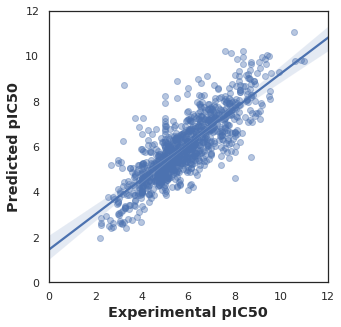

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show